# Multi-task optimization of KB mirrors

Often, we want to optimize multiple aspects of a system; in this real-world example aligning the Kirkpatrick-Baez mirrors at the TES beamline's endstation, we care about the horizontal and vertical beam size, as well as the flux. 

We could try to model these as a single task by combining them into a single number (i.e., optimization the beam density as flux divided by area), but our model then loses all information about how different inputs affect different outputs. We instead give the optimizer multiple "tasks", and then direct it based on its prediction of those tasks. 

In [1]:
%run -i ../../../examples/prepare_bluesky.py
%run -i ../../../examples/prepare_tes_shadow.py

In [2]:
toroid.offz

SirepoSignal(name='toroid_offz', parent='toroid', value=0.0, timestamp=1691733474.3013024)

In [3]:
from bloptools.bayesian import Agent
from bloptools.experiments.sirepo.tes import w9_digestion

dofs = [
    {"device": kbv.x_rot, "limits": (-0.1, 0.1), "kind": "active"},
    {"device": kbh.x_rot, "limits": (-0.1, 0.1), "kind": "active"},
]

tasks = [
    {"key": "flux", "kind": "maximize", "transform": "log"},
    {"key": "w9_fwhm_x", "kind": "minimize", "transform": "log"},
    {"key": "w9_fwhm_y", "kind": "minimize", "transform": "log"},
]

agent = Agent(
    dofs=dofs,
    tasks=tasks,
    dets=[w9],
    digestion=w9_digestion,
    db=db,
)

RE(agent.initialize("qr", n_init=16))

New stream: 'primary'
+-----------+------------+------------+------------+------------+
|   seq_num |       time |  kbv_x_rot |  kbh_x_rot |    w9_flux |
+-----------+------------+------------+------------+------------+


|         1 | 05:58:02.0 |     -0.029 |      0.087 |   1955.179 |


|         2 | 05:58:07.4 |      0.072 |     -0.082 |   4658.110 |


|         3 | 05:58:12.7 |      0.037 |      0.018 |   3732.007 |


|         4 | 05:58:18.0 |     -0.063 |     -0.014 |   4248.406 |


|         5 | 05:58:23.3 |     -0.077 |      0.045 |   3271.651 |


|         6 | 05:58:28.7 |      0.022 |     -0.050 |   4632.558 |


|         7 | 05:58:34.0 |      0.082 |      0.051 |   2911.505 |


|         8 | 05:58:39.4 |     -0.019 |     -0.056 |   4686.669 |


|         9 | 05:58:44.7 |     -0.001 |      0.006 |   3955.364 |


|        10 | 05:58:50.0 |      0.099 |     -0.012 |   3769.124 |


|        11 | 05:58:55.4 |      0.008 |      0.088 |   1923.183 |


|        12 | 05:59:00.7 |     -0.091 |     -0.092 |   4889.151 |


|        13 | 05:59:06.0 |     -0.055 |      0.074 |   2504.054 |


|        14 | 05:59:11.3 |      0.045 |     -0.069 |   4720.779 |


|        15 | 05:59:16.7 |      0.061 |      0.030 |   3437.340 |


|        16 | 05:59:22.0 |     -0.039 |     -0.025 |   4396.680 |
+-----------+------------+------------+------------+------------+
generator list_scan ['795e0c3c'] (scan num: 1)


('795e0c3c-8b0d-4d1e-a818-a022a6347f07',)

For each task, we plot the sampled data and the model's posterior with respect to two inputs to the KB mirrors. We can see that each tasks responds very differently to different motors, which is very useful to the optimizer. 

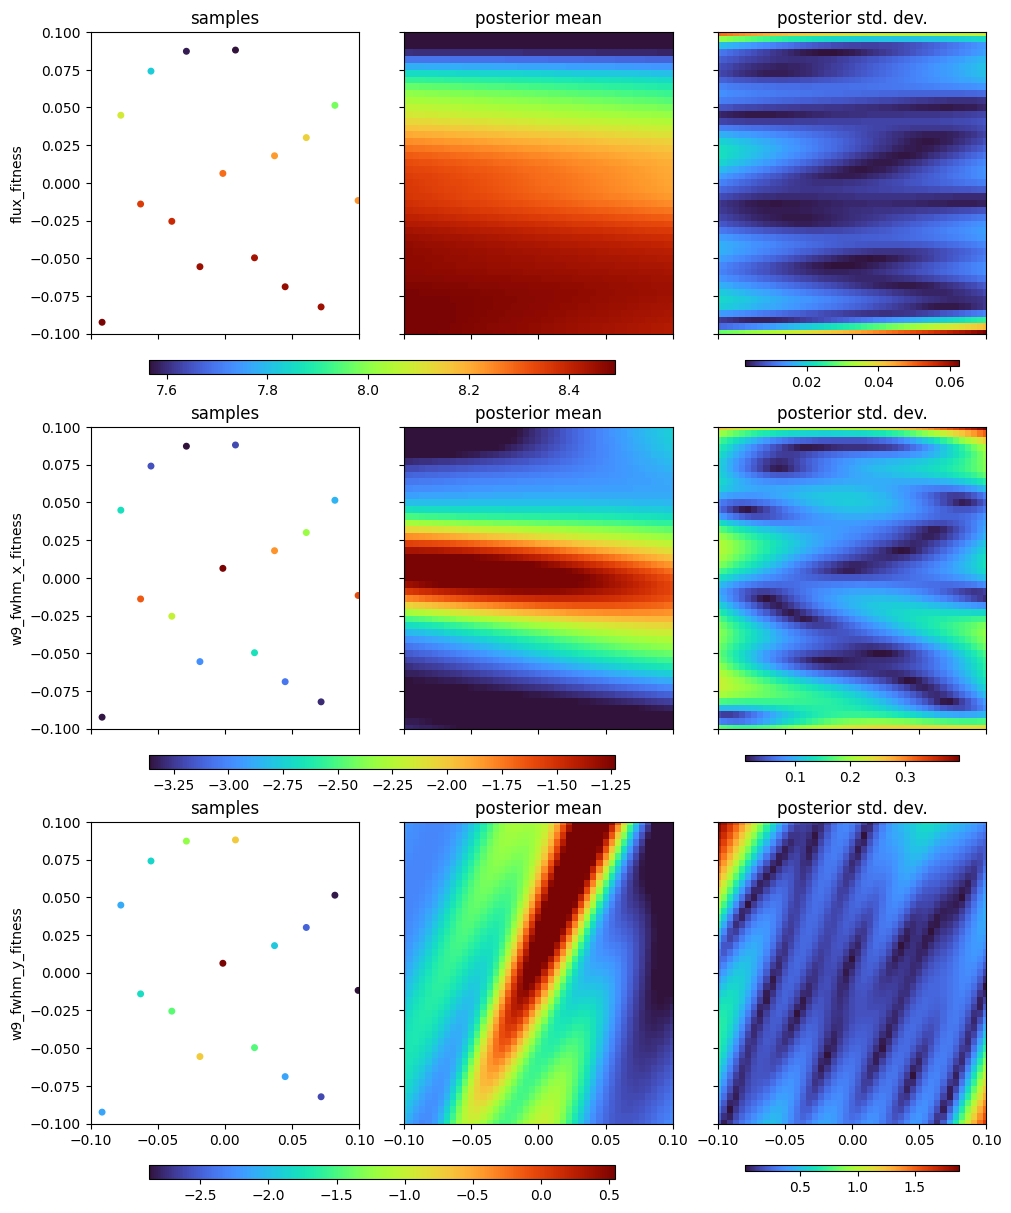

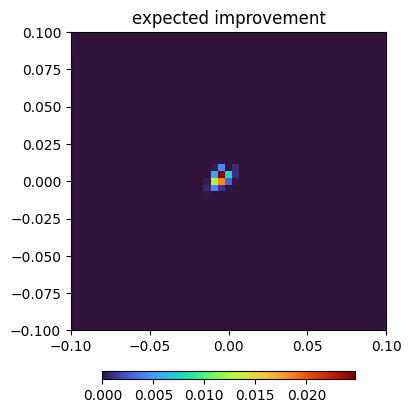

In [4]:
agent.plot_tasks()
agent.plot_acquisition(strategy=["ei", "pi", "ucb"])

We should find our optimum (or something close to it) on the very next iteration:

New stream: 'primary'
+-----------+------------+------------+------------+------------+
|   seq_num |       time |  kbv_x_rot |  kbh_x_rot |    w9_flux |
+-----------+------------+------------+------------+------------+


|         1 | 05:59:35.1 |      0.100 |     -0.100 |   4436.179 |
+-----------+------------+------------+------------+------------+
generator list_scan ['ec0268d3'] (scan num: 2)


New stream: 'primary'
+-----------+------------+------------+------------+------------+
|   seq_num |       time |  kbv_x_rot |  kbh_x_rot |    w9_flux |
+-----------+------------+------------+------------+------------+


|         1 | 05:59:42.7 |     -0.005 |      0.003 |   4017.508 |
+-----------+------------+------------+------------+------------+
generator list_scan ['2e6ef548'] (scan num: 3)


/usr/share/miniconda3/envs/bloptools-py3.10/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


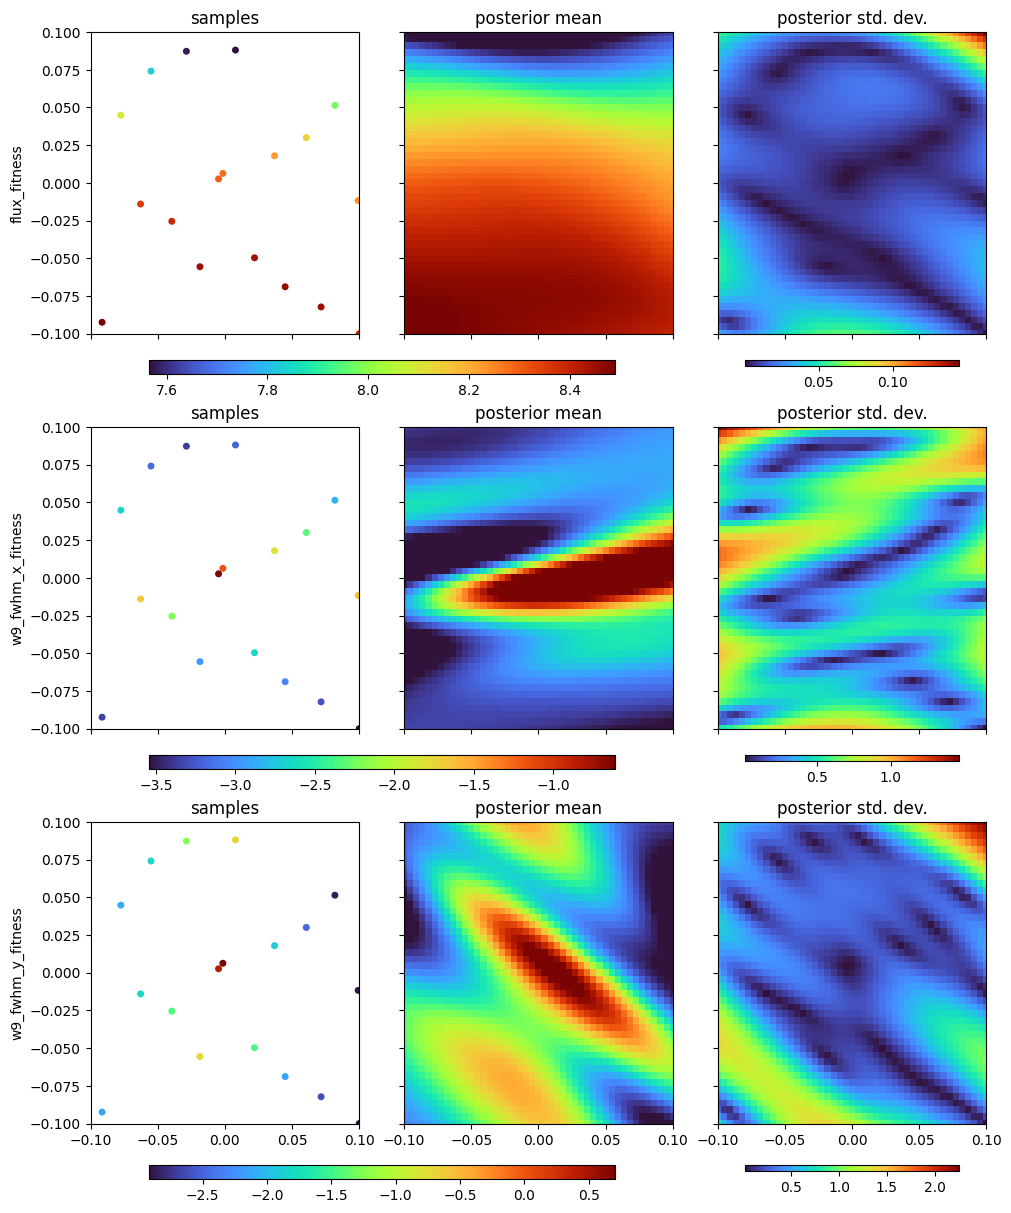

In [5]:
RE(agent.learn("ei", n_iter=2))
agent.plot_tasks()

The agent has learned that certain dimensions affect different tasks differently!